# Coursework 2
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín

In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using Plots
using LinearAlgebra

In [3]:
default(size=(600, 300))
new = [CartesianIndex()];

## Question 1: pseudospectral methods

### a) Evaluation of a first derivative

Write a program that numerically evaluates the first derivative using pseudo-spectral methods of a function $f(x)$ evaluated a set of grid of points  $\left\{x_n = \frac{a + b}{2} + \frac{a - b}{2}\cos\theta_n\right\}_{n=0}^N$; where $a, b$ are the limits of the evaluation interval, $\theta_n = n\pi / N$. Evaluate the derivatives using the approximation

$$
    f'(x_n) = \sum_{m=0}^N D_{nm}f(x_m)
$$

Where $D_{nm}$ are the elements of the $(N+1)\times(N+1)$ Chebyshev derivative matrix given by

$$
    {\bf D}_{00} = -\frac{2N^2 + 1}{3(b-a)}
$$


$$
    {\bf D}_{nn} = \frac{\cos\theta_n}{(b-a) \sin^2\theta_n}
$$

$$
    {\bf D}_{NN} = \frac{2N^2+1}{3(b-a)}
$$


$$
    {\bf D}_{nm} = \frac{2 c_n (-1)^{n + m}}{(b-a) c_m (\cos \theta_m - \cos\theta_n)}
$$

With $c_n = 1 + \mathbb{1}(n=0) + \mathbb{1}(n=N)$

In [365]:
c(n, N) = 1 + (n == 0) + (n == N)


"""
Evaluate an entry of the chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

Parameters
----------
a: int
    Initial value
b: int
    Final value
n: int
    row of the matrix
m: int
    column of the matrix
N: int
    Lenght of matrix - 1


Returns
-------
array: (N+1) × (N+1) chebyshev matrix
"""
function D_entry_chebyshev(a, b, n, m, N)
    n, m = n - 1, m - 1
    θn = n * pi / N
    θm = m * pi / N
    
    if n == 0 && m == 0
        D = -(2N ^ 2 + 1) / 3(b - a)
    elseif n == N && m == N
        D = (2N ^ 2 + 1) / 3(b - a)
    elseif n == m
        D = cos(θn) / ((b - a) * sin(θn) ^ 2)
    else
        D = (2c(n, N) * (-1) ^ (n + m)) / ((b - a) * c(m, N) * (cos(θm) - cos(θn)))
    end
    
    return D
end


"""
Create a Chebyshev derivative matrix of a
function f:R->R evaluated from a to b in (N + 1) steps

Parameters
----------
a: int
    Lower bound of evaluation
b: int
    Upper bound of evaluation
N: int
    Number of gridpoints to evaluate
"""
function D_chebyshev(a, b, N)
    D = zeros(N + 1, N + 1)
    for n=1:N+1
        for m=1:N+1
            D[n, m] = D_entry_chebyshev(a, b, n, m, N)
        end
    end
    
    return D
end


"""
Create a grid point of N+1 values from
a to b to be used in the Chebyshev pseudospectral method

Parameters
----------
a: int
    Lower evaluation bound
b: int
    Upper evaluation bound
N: int
    Total number of points from a to b (plus 1)
"""
function range_chebyshev(a, b; lenght)
    θvals = collect(0:lenght) .* pi / lenght
    xvals = (a + b) / 2. .+ (a - b) / 2 .* cos.(θvals)
    
    return xvals
end


"""
Evaluate the derivative of a function f:R->R using a
pseudo-spectral method using a Chebyshev
"""
function DChebyshev(f, a, b, N)
    xrange = range_chebyshev(a, b, lenght=N)
    D = D_chebyshev(a, b, N)
    # For stability and accuracy purposes, we replace each element
    # of the main diagonal with the negative sum of all matrix elements
    # in the same row
    D[diagind(D)] = -sum(D .* (ones(N+1, N+1) - I), dims=2)
    df_values = D * f.(xrange)
    
    return xrange, df_values
end


DChebyshev

In [374]:
f(x) = exp(-x^2)
df(x) = -2x * exp(-x^2)

df (generic function with 1 method)

In [367]:
f(x) = sin(-x^2)
df(x) = -2x * cos(-x^2)

df (generic function with 1 method)

### b) Numerical error

In this section we approximate the derivative of a function $f$ and compare it against its analytical solution by plotting the difference
    
$$
    \frac{d}{dx}f_\texttt{numerical}(x) - \frac{d}{dx}f_\texttt{analytical}(x)
$$

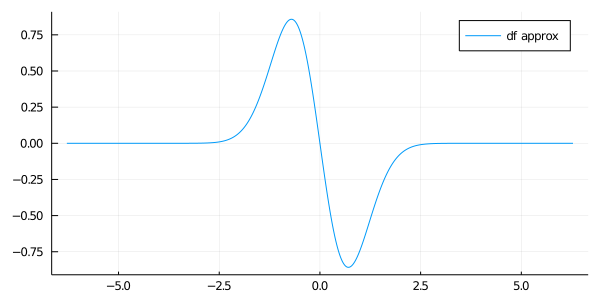

In [375]:
a, b = -2pi, 2pi
N = 1000
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df_approx, label="df approx")

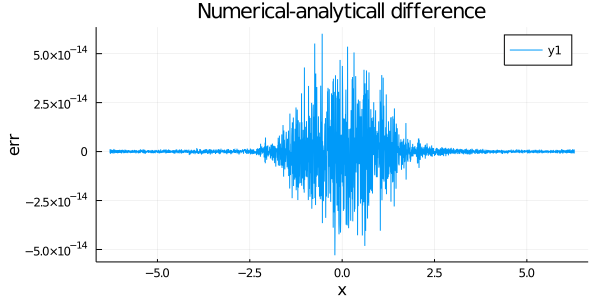

In [382]:
N = 3500
xrange, df_approx = DChebyshev(f, a, b, N)
plot(xrange, df.(xrange) - df_approx, ylabel="err", xlabel="x",
     title="Numerical-analyticall difference")

In [383]:
log.(sum(abs.(df.(xrange) - df_approx)))

-25.342840450025857

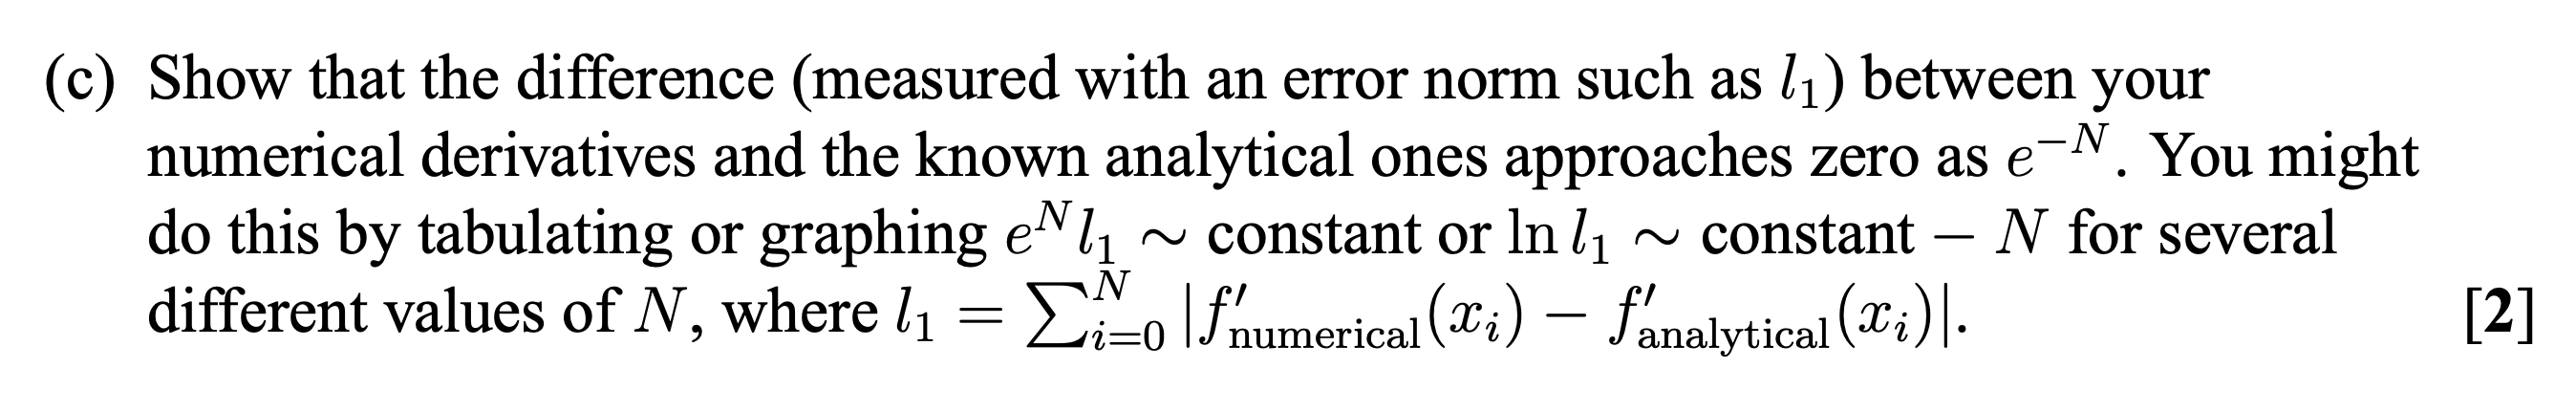

### c) L1 error norm

In this section we show that the difference between our numerical derivatives and the known analytical ones approaches zero as

In [354]:
Nmax = 1_000

Nrange = 10:100:Nmax
l1_values = zeros(length(Nrange))
for (i, N) in enumerate(Nrange)
    xrange, df_approx = DChebyshev(f, a, b, N)
    l1 = sum(abs.(df.(xrange) - df_approx))
    l1_values[i] = l1
end

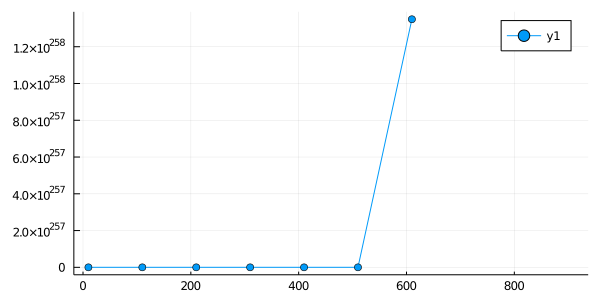

In [355]:
plot(Nrange, exp.(Nrange) .* l1_values, marker=true)

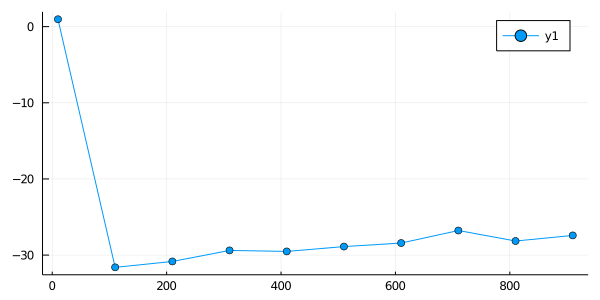

In [338]:
plot(Nrange, log.(l1_values), marker=true)

In [323]:
l1_values

10-element Array{Float64,1}:
 2.641260414101726
 1.875725994844446e-14
 4.063375407662384e-14
 1.7301756905591184e-13
 1.513598983546837e-13
 2.8632664209120195e-13
 4.55306570687524e-13
 2.358901424842026e-12
 5.942170178900821e-13
 1.241059115827022e-12

In [320]:
exp.(Nrange)

10-element Array{Float64,1}:
 22026.465794806718
     5.92097202766467e47
     1.5916266403779241e91
     4.278478855371123e134
     1.1501052352020995e178
     3.091617597639242e221
     8.310630260154467e264
    Inf
    Inf
    Inf

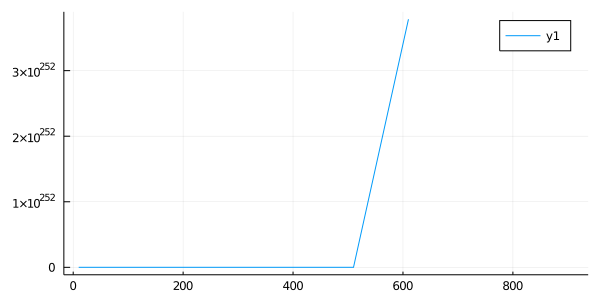

In [317]:
plot(Nrange, exp.(Nrange) .* l1_values)